In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Wind:
    """ relative winddirection for now as input from 0-180 on the boat looking in the heading direction
    H = [m] height of the vessel m
    B = [m] width of the vessel 
    L = [m] length of the vessel
    rel_winddir = [deg] relative winddirection from 0-180 from looking at winddirection and heading, 0 is from the head, 180 from stern ! manually
    loaded_depth = [m] depth of vessel loaded
    unloaded_depth = [m] depth of vessel unloaded
    load = 'loaded'/'unloaded', for depth and cd
    V_g = [m/s] speed over ground 
    heading = [deg] direction 0 degrees is north , 45 degrees is northeast. 
    winddirection = [deg] geographic wind direction
    U_wind = [m/s] windspeed
    rho_air = [kg/m3] density of air
    rho_water = [kg/m3] density of water
    
    - H_e: vessel height unloaded
    - H_f: vessel height loaded
    - T_e: draught unloaded
    - T_f: draught loaded
    """
    def __init__(
        #""" relative winddirection for now as input from 0-180 on the boat looking in the heading direction
        #"""
        self,
        B, 
        L,
        H ,
        rel_winddir,
        loaded_depth,
        unloaded_depth,
        load = 'loaded',
     
        V_g = [],
        heading = 40,# degrees (NE)
        winddirection = 60,# degrees (not relative but real)
        U_wind = 2,
        rho_air = 1.225,
        rho_water = 1025
        
        
        
    ):
        self.B = B
        self.L = L
        self.H = H
        self.load = load
        self.V_g = V_g
        self.heading = heading
        self.winddirection = winddirection
        self.U_wind = U_wind
        self.rho_air = rho_air
        self.rel_winddir = rel_winddir
        self.loaded_depth = loaded_depth
        self.unloaded_depth = unloaded_depth
        self.rho_water = rho_water
       
    
    def calculate_rel_winddir (self):
        #phi_w_ref = angle of attack  
        #(https://sciendo.com/pdf/10.2478/ntpe-2018-0013)
        # pffff still not found the right relations for angle, winddirection. 
        # not yet in, ook schijnbare wind niet. 
            
        self.phi_w_ref = self.winddirection - self.heading  
        return self.phi_w_ref
    
    def calculate_C_drag(self):
        # for a tanker ( ITTC: ) 
        # cda = -cx (cx given for ships)
        
        cd=[[0,0.86,0.96],[10,0.76,0.93],[20,0.62,0.85],
        [30,0.45,0.73],[40,0.32,0.62],[50,0.21,0.47],
        [60,0.13,0.34],[70,0.06,0.17],[80,0.04,0.06],
        [90,-0.02,-0.05],[100,-0.08,-0.14],[110,-0.19,-0.22],
        [120,-0.29,-0.29],[130,-0.38,-0.40],[140,-0.47,-0.53],
        [150,-0.56,-0.66],[160,-0.61,-0.75],[170,-0.66,-0.79],
        [180,-0.63,-0.77]]
    
        df=pd.DataFrame(cd,columns=['Relative wind direction','loaded','unloaded'])
    
        if self.load == 'loaded':
            self.C_drag = df['loaded'].where(df['Relative wind direction'] == self.rel_winddir).dropna().values[0]
    
        elif self.load == 'unloaded':
            self.C_drag = df['unloaded'].where(df['Relative wind direction'] == self.rel_winddir).dropna().values[0]
    
        return self.C_drag
    
    def calculate_Cd_0(self):
        if self.load == 'loaded':
            self.Cd_0 = 0.86                            
        elif self.load == 'unloaded':
            self.Cd_0 = 0.96
        return self.Cd_0 
    
    def calculate_H_above_water(self):
        if self.load == 'loaded':
            self.H_above = self.H - self.loaded_depth 
        elif self.load == 'unloaded':
            self.H_above = self.H - self.unloaded_depth
        return self.H_above
    
    def calculate_A_xv(self):
        #cubed barge assumed 
        angle=0
        if self.rel_winddir <91:
            self.A_xv = self.calculate_H_above_water() * (self.B * np.cos(self.rel_winddir*np.pi/180) + self.L * np.sin(self.rel_winddir*np.pi/180))
            self.A_ydir = self.calculate_H_above_water() * self.L * np.sin(self.rel_winddir*np.pi/180)
        elif self.rel_winddir > 90:
            angle = 90-(self.rel_winddir -90) # symmetric shape front and back. 
            self.A_xv = self.calculate_H_above_water() * (self.B * np.cos(angle*np.pi/180) + self.L * np.sin(angle*np.pi/180))
            self.A_ydir = self.calculate_H_above_water() * self.L * np.sin(angle*np.pi/180)
        return self.A_xv , angle , self.A_ydir
    
    def calculate_wind_resistance(self):
        self.R_wind = 0.5 * self.calculate_C_drag() * self.rho_air * self.calculate_A_xv()[0] * self.U_wind **2 - 0.5 * self.rho_air * self.calculate_Cd_0() * self.calculate_A_xv()[0] * self.V_g **2
    # negative value is in the Cd  value. so negative winddirection gives negative value because of cd. 
        return self.R_wind 
    
    # for the passive rudder: 
    # 1. calculate the moment caused by wind and distance to centre of gravity # assume stays constant in middle
    # 2. moment for counteraction is same, with distance to centre of gravity (assume stays constant) force fN,delta_r can be calculated. 
    # 3. depends on angle delta_R the force as well as the moment, look at different angles so that smallest angle with R is chosen
    # 4. print angle so that moment is the same.
    # 5. calculate Rrx with Rrx = abs(Fn*sin(delta_r))
    
    def calculate_moment_wind(self):
        self.wind_ydir = 0.5 * self.rho_air * self.calculate_A_xv()[2] * self.U_wind **2 * 1 
        self.mom_wind = self.wind_ydir * self.L
        # cd assumed 1, not sure if same cd as 90 deg as that is very small number.
        return self.wind_ydir , self.mom_wind
        
    def calculate_Mry(self):
        #calculate with known angle of rudder
        self.dis_to_cog = self.L / 2
        lamda = 2 # first assumption https://marineengineeringonline.com/tag/aspect-ratio/
        A_R = 1/60 * self.B * self.L #https://www.marinesite.info/2021/05/aspect-ratio-force-acting-on-rudder.html
        self.dr = 40
        FN =   0.5 * self.rho_water * ( 6.13 * lamda/(lamda+2.25))* A_R * self.V_g **2 * np.sin(self.dr  * np.pi/180)      
        Rry = np.cos(self.dr * np.pi/180) *  FN
        Rrx = np.abs(FN*np.sin(self.dr * np.pi/180)) 
        Mry = Rry * self.dis_to_cog    
#         #alpha_r = delta_r/2 assumption
#         #ignored hull factor ay on rudder force for now
        
        return Rry, Rrx, Mry, self.dr , FN 
    
    def calculate_angle(self):
        # calculate angle of rudder and moments and resistance
        lamda = 2 
        A_R = 1/60 * self.B * self.L
        dr = np.arange(1,41,1)
        windmoment = self.calculate_moment_wind()[1]
        restmoment = self.calculate_Mry()[2]-windmoment
      #  if restmoment > 0:
      #      Mry = self.calculate_Mry()[2]
      #      Rrx = self.calculate_Mry()[1]
      #      angle = self.calculate_Mry()[3]
            
        #else: # restmoment<0
        Mry = 0
        angle = 0
        Rrx = 0
        while Mry < windmoment:
            angle += 1
            FN =  0.5 * self.rho_water * ( 6.13 * lamda/(lamda+2.25))* A_R * self.V_g **2 * np.sin(angle  * np.pi/180) 
            Rry = np.cos(angle * np.pi/180) *  FN
            Mry = Rry * self.L/2
            Rrx = np.abs(FN*np.sin(angle * np.pi/180))
               # if  Mry > windmoment:
               #     angle = dr[i]
               #     Rrx = np.abs(FN*np.sin(dr[i] * np.pi/180))
            if angle == 40:
                break
        
        

            
        return angle, windmoment, Mry, Rrx, restmoment

            



In [3]:
p =  Wind(B = 11,L = 60,rel_winddir=20,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind =13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
print(p)

In [4]:
#print(p.calculate_FN_cosdr()[1],'H_above')
print(p.calculate_A_xv(), 'Axv')
print(p.calculate_C_drag(), 'C_drag')
print(p.calculate_rel_winddir(), 'rel_winddir')
print(p.calculate_moment_wind(), 'windmoment')

(16.97180508550181, 0, 11.286664729747063) Axv
0.62 C_drag
20 rel_winddir
(1316.5273640689816, 78991.6418441389) windmoment


In [5]:
p.calculate_wind_resistance()

1224.1756219450424

In [6]:

print(p.calculate_angle(), 'extra resistance')
print(p.calculate_Mry()[2])
print(p.calculate_moment_wind()[1])
print(p.calculate_angle()[4])

(33, 78991.6418441389, 80225.42331904297, 1736.633302362371, 7491.86941665379) extra resistance
86483.51126079269
78991.6418441389
7491.86941665379


In [7]:
# invoegen
# stop als te veel, sensitivity analysis. 
# stappen op een rijtje zetten voor de komende tijd. 
# uitvoeren en uren maken., uren die gemaakt moeten worden zijn er al genoeg.
# met en zonder wind laten zien verschil. 
# stroming in goede richting. -> aan /  uit. 


In [8]:
## loaded, vg=0.3 m/s

U138D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D45=  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D90=  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D135=  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U138D180=  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 13.8 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

U107D0=  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D45 =  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D90 =  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D135 =  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U107D180 =  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 10.7 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

U79D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D45 =  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D90 =  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D135 =  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U79D180 =  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 7.9 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

U54D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D45 =  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D90 =  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D135 =  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U54D180 =  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 5.4 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


U33D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D45 =  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D90 =  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D135 =  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U33D180 =  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 3.3 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)


U15D0 =  Wind(B = 11,L = 60,rel_winddir=0,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D45 =  Wind(B = 11,L = 60,rel_winddir=40,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D90 =  Wind(B = 11,L = 60,rel_winddir=90,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D135 =  Wind(B = 11,L = 60,rel_winddir=130,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)
U15D180 =  Wind(B = 11,L = 60,rel_winddir=180,load = 'loaded',V_g = 0.6,heading = 40,winddirection = 60,U_wind = 1.5 ,rho_air = 1.225, H = 4, loaded_depth = 3.45, unloaded_depth = 2)

# 4 rel wind directions
# 1 speeds , in principe vg3
# only loaded
# 6 U_wind 

# D0
# D45
# D90
# D135
# D180 

# W138 -> Bft 6
# W107 -> Bft 5
# W79 -> Bft 4
# W54 -> Bft 3
# W33 -> Bft 2
# W15 -> Bft 1





2418.9427467282426  N Max


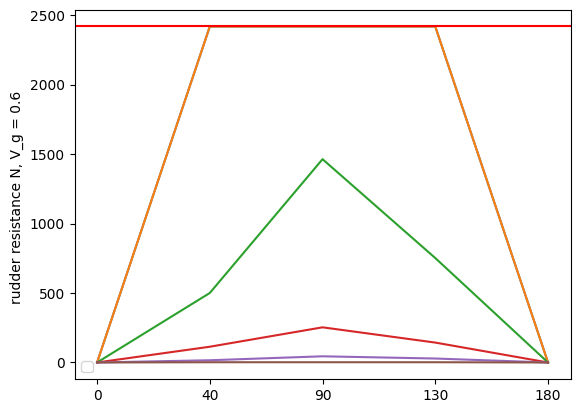

In [9]:
a1 = U138D0.calculate_angle()
a2 = U138D45.calculate_angle()
a3 = U138D90.calculate_angle()
a4 = U138D135.calculate_angle()
a5 = U138D180.calculate_angle()

b1 = U107D0.calculate_angle()
b2 = U107D45.calculate_angle()
b3 = U107D90.calculate_angle()
b4 = U107D135.calculate_angle()
b5 = U107D180.calculate_angle()

c1 = U79D0.calculate_angle()
c2 = U79D45.calculate_angle()
c3 = U79D90.calculate_angle()
c4 = U79D135.calculate_angle()
c5 = U79D180.calculate_angle()

d1 = U54D0.calculate_angle()
d2 = U54D45.calculate_angle()
d3 = U54D90.calculate_angle()
d4 = U54D135.calculate_angle()
d5 = U54D180.calculate_angle()

e1 = U33D0.calculate_angle()
e2 = U33D45.calculate_angle()
e3 = U33D90.calculate_angle()
e4 = U33D135.calculate_angle()
e5 = U33D180.calculate_angle()

f1 = U15D0.calculate_angle()
f2 = U15D45.calculate_angle()
f3 = U15D90.calculate_angle()
f4 = U15D135.calculate_angle()
f5 = U15D180.calculate_angle()


# print(a1,a2,a3,a4,a5)
# print(b1,b2,b3,b4,b5)
# print(c1,c2,c3,c4,c5)
# print(d1,d2,d3,d4,d5)
# print(e1,e2,e3,e4,e5)
# print(f1,f2,f3,f4,f5)

a = (a1[3],a2[3],a3[3],a4[3],a5[3])
b = (b1[3],b2[3],b3[3],b4[3],b5[3])
c = (c1[3],c2[3],c3[3],c4[3],c5[3])
d = (d1[3],d2[3],d3[3],d4[3],d5[3])
e = (e1[3],e2[3],e3[3],e4[3],e5[3])
f = (f1[3],f2[3],f3[3],f4[3],f5[3])

x = ['0','40','90','130','180'] 
plt.figure()
plt.legend(['u13.8','u10.7','u7.9','u5.4','u3.3','u1.5'])
plt.plot(x,a,)
plt.plot(x,b,)
plt.plot(x,c,)
plt.plot(x,d,)
plt.plot(x,e,)
plt.plot(x,f,)

plt.ylabel('rudder resistance N, V_g = 0.6 ')
plt.axhline(p.calculate_Mry()[1],color = 'r')

print(p.calculate_Mry()[1], ' N Max') # klopt dit wel, dit is voor een snelheid toch.




Text(0, 0.5, 'Wind resistance N, V_g = 0.6 ')

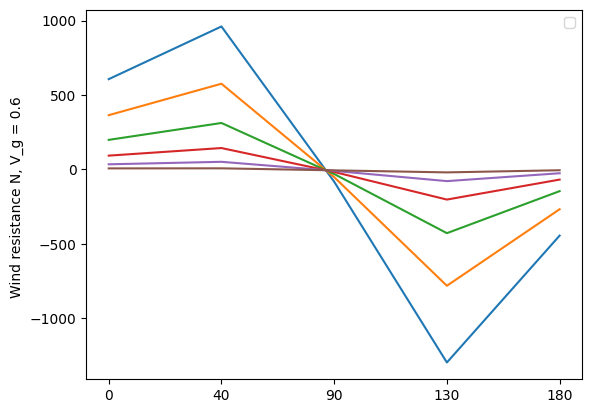

In [10]:
# wind resistance

g1 = U138D0.calculate_wind_resistance()
g2 = U138D45.calculate_wind_resistance()
g3 = U138D90.calculate_wind_resistance()
g4 = U138D135.calculate_wind_resistance()
g5 = U138D180.calculate_wind_resistance()

h1 = U107D0.calculate_wind_resistance()
h2 = U107D45.calculate_wind_resistance()
h3 = U107D90.calculate_wind_resistance()
h4 = U107D135.calculate_wind_resistance()
h5 = U107D180.calculate_wind_resistance()

i1 = U79D0.calculate_wind_resistance()
i2 = U79D45.calculate_wind_resistance()
i3 = U79D90.calculate_wind_resistance()
i4 = U79D135.calculate_wind_resistance()
i5 = U79D180.calculate_wind_resistance()

j1 = U54D0.calculate_wind_resistance()
j2 = U54D45.calculate_wind_resistance()
j3 = U54D90.calculate_wind_resistance()
j4 = U54D135.calculate_wind_resistance()
j5 = U54D180.calculate_wind_resistance()

k1 = U33D0.calculate_wind_resistance()
k2 = U33D45.calculate_wind_resistance()
k3 = U33D90.calculate_wind_resistance()
k4 = U33D135.calculate_wind_resistance()
k5 = U33D180.calculate_wind_resistance()

l1 = U15D0.calculate_wind_resistance()
l2 = U15D45.calculate_wind_resistance()
l3 = U15D90.calculate_wind_resistance()
l4 = U15D135.calculate_wind_resistance()
l5 = U15D180.calculate_wind_resistance()

g = (g1,g2,g3,g4,g5)
h = (h1,h2,h3,h4,h5)
i = (i1,i2,i3,i4,i5)
j = (j1,j2,j3,j4,j5)
k = (k1,k2,k3,k4,k5)
l = (l1,l2,l3,l4,l5)

x = ['0','40','90','130','180'] 
plt.figure()
plt.legend(['u13.8','u10.7','u7.9','u5.4','u3.3','u1.5'])
plt.plot(x,g)
plt.plot(x,h)
plt.plot(x,i)
plt.plot(x,j)
plt.plot(x,k)
plt.plot(x,l)

plt.ylabel('Wind resistance N, V_g = 0.6 ')


In [11]:
# daar gaat het mis, is logisch.. Even tijdelijke oplossing voor zoeken. 
# d40 van maken, 45 staat niet in cd lijst. 

In [12]:
# resistance parts. laten zien. loaded/unloaded -> daar ook berekeningetje voor maken. Laten zien met wind dat het niet te doen is fully unloaded.
# omgebouwde schepen gaat het om. 
# precieze plek moet meer naar gekeken worden. 
# pijplediing moet verder naar gekeken worden. 
# cycle definieren als lijn voor wat ik als uitvalsbasis neem en welke aannames daarin zitten. Met plaatjes. 
# kijken naar feedback jan op vorige. 
# ook relatieve invloed in vergelijking met andere resistances laten zien. 
# sensitivity ook laten zien wat de minimale snelheid is zodat dit niet gebeurt. -> voor loaded en dan paar verschillende snelheden. Moet minstens 60 graden kunnen varen bijv. 
# wat meer punten toevoegen misschien. 
# wat voorbeeldjes laten zien ook. van dat het klopt. 
# wat als met stroom mee?,, dan helemaal geen snelheid?/
# ignore vaartwind door stroming. 
# Dit voor aantal snelheden. 
# meer punten , alle punten per 10 , 0-180? -> loopen. 
# 2 snelehden. 
# kritieke regionen bepalen voor rudder.
# kan ook meerdere snelheden voor de punten buiten de region die werkt. -> wanneer erbuiten. 
# alle gedeeltes duidelijk opschrijven met formules en aannames. 
# als met stroom mee? dan helemaal niet corrigeren. 
# golven -> +/- met richtingen van compenseren. 
# relatieve grootte laten zien alle resistances, -> dat met man produceren, kijken wat er niet lukt komende maandag. 
# dus moet morgen. 
# loaded / unloaded

[605.754072, 3378.796365309362, 2335.6995867282426, 1120.5278802478065, -445.73777325]


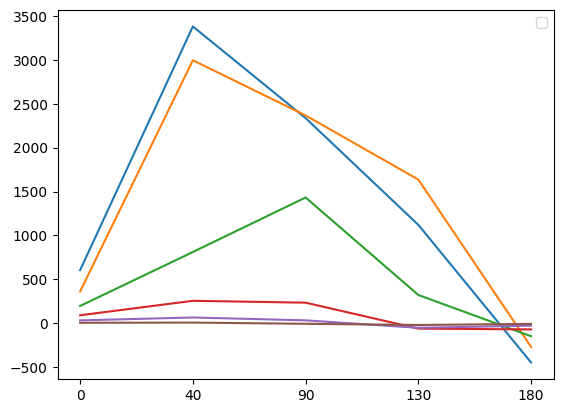

In [13]:
# total added resistance
m = [a[i] + g[i] for i in range(len(a))]
n = [b[i] + h[i] for i in range(len(b))]
o = [c[j] + i[j] for j in range(len(c))]
p = [d[i] + j[i] for i in range(len(d))]
q = [e[i] + k[i] for i in range(len(e))]
r = [f[i] + l[i] for i in range(len(a))]
print(m)
x = ['0','40','90','130','180'] 
plt.figure()
plt.legend(['u13.8','u10.7','u7.9','u5.4','u3.3','u1.5'])
plt.plot(x,m)
plt.plot(x,n)
plt.plot(x,o)
plt.plot(x,p)
plt.plot(x,q)
plt.plot(x,r)

# verschillende kleuren is verschillende u_ wind.
#Als meer stappen dan wordt het gezeik met letters.. 